##FullSubsetSelection

In [ ]:
library(ISLR)
names(Hitters)
summary(Hitters)

In [ ]:
Hitters=na.omit(Hitters)
dim(Hitters)
sum(is.na(Hitters))

In [ ]:
library(leaps)
regfit.full=regsubsets(Salary~.,data=Hitters)
summary(regfit.full)

In [ ]:
regfit.full=regsubsets(Salary~.,data=Hitters,nvmax=19)
reg.summary=summary(regfit.full)
names(reg.summary)
reg.summary$rsq

In [ ]:
#Use Cp,AIC,BIC, AdjR2 to select best model between diff p#
par(mfrow=c(2,2))
plot(reg.summary$rss,xlab="Number of Variables",ylab="RSS",type="l") #connect dots with line
plot(reg.summary$adjr2,xlab="Number of Variables",ylab="Adjusted RSq",type="l") #connect dots with line
#which.max(reg.summary$adjr2)
points(11,reg.summary$adjr2[11],col="red",cex=2,pch=20)
plot(reg.summary$cp,xlab="Number of Variables",ylab="Cp",type="l") #connect dots with line
cp.min=which.min(reg.summary$cp)
points(cp.min,reg.summary$cp[cp.min],col="red",cex=2,pch=20)
plot(reg.summary$bic,xlab="Number of Variables",ylab="BIC",type="l") #connect dots with line
bic.min=which.min(reg.summary$bic)
points(bic.min,reg.summary$bic[bic.min],col="red",cex=2,pch=20)

In [ ]:
plot(regfit.full,scale="r2")
#plot(regfit.full,scale="adjr2")
#plot(regfit.full,scale="Cp")
#plot(regfit.full,scale="bic")

In [ ]:
coef(regfit.full,6)

##Forward &Backward Selection

In [ ]:
regfit.fwd=regsubsets(Salary~.,data=Hitters,nvmax=19,method="forward")
summary(regfit.fwd)
regfit.bwd=regsubsets(Salary~.,data=Hitters,nvmax=19,method="backward")
summary(regfit.bwd)
regfit.bwd$call[[2]]

In [ ]:
coef(regfit.full,7)
coef(regfit.fwd,7)
coef(regfit.bwd,7)


##best subset selection with validation set

In [ ]:
#because regsubsets dont't have predict() function. We have to pull out the coef to do CV
set.seed(1)
train=sample(c(TRUE,FALSE),nrow(Hitters),rep=T)
test=(!train)
regfit.best=regsubsets(Salary~.,data=Hitters[train,],nvmax=19)
test.mat=model.matrix(Salary~.,Hitters[test,])
val.errors=rep(NA,19)
for(i in 1:19){
    coefi=coef(regfit.best,id=i)
    pred=test.mat[,names(coefi)]%*%coefi
    val.errors[i]=mean((Hitters$Salary[test]-pred)^2)
}
val.errors
which.min(val.errors)
coef(regfit.best,10)

In [ ]:
predict.regsubsets=function(object,newdata,id){
    form=as.formula(object$call[[2]])
    mat=model.matrix(form,newdata)
    coefi=coef(object,id=id)
    xvars=names(coefi)
    mat[,xvars]%*%coefi
}

##best subset selection with CV

In [ ]:
#same here. have to write CV procedures ourself. no prebuid CV in regsubsets
k=10
set.seed(1)
folds=sample(1:k,nrow(Hitters),rep=T)
cv.errors=matrix(NA,k,19,dimnames=list(NULL,paste(1:19)))
for(j in 1:k){ #use data not in jth fold
    best.fit=regsubsets(Salary~.,data=Hitters[folds!=j,],nvmax=19)
    for(i in 1:19){
        pred=predict.regsubsets(best.fit,Hitters[folds==j,],i)
        cv.errors[j,i]=mean((Hitters$Salary[folds==j]-pred)^2)
    }
}
mean.cv.errors=apply(cv.errors,2,mean)
plot(mean.cv.errors,type="b")

##Ridge

In [ ]:
#glmnet()只accept matrix X and response Y, 用model.matrix split一下
x=model.matrix(Salary~.,Hitters)[,-1]
y=Hitters$Salary
library(glmnet)

In [ ]:
#Ridge: alpha=0, Lasso: alpha=1. 默认X会standardized,除非standardized=False
#the lambda could be a list of numbers, or just a single number. Here range from 10^10 to 10^-2
grid=10^seq(10,-2,length=100) 
ridge.mod=glmnet(x,y,alpha=0,lambda=grid)
dim(coef(ridge.mod)) #20 rows of features, 100 columns(vectors) coresponding lambda

In [ ]:
#overview of ridge coef with diffrent lambda
ridge.mod$lambda[50]
coef(ridge.mod)[,50]
sqrt(sum(coef(ridge.mod)[-1,50]^2)) #L2 norm without intercept
ridge.mod$lambda[60]
coef(ridge.mod)[,60]
sqrt(sum(coef(ridge.mod)[-1,60]^2)) #L2 norm without intercept

In [ ]:
#求特定lambda的coef，这里lambda=50
predict(ridge.mod,s=50,type="coefficient")[,1]

In [ ]:
#对半分的validation set approach
set.seed(1)
train=sample(1:nrow(x),nrow(x)/2)
test=(-train)
y.test=y[test]

In [ ]:
#用一般的training set来做ridge 
ridge.mod=glmnet(x[train,],y[train],alpha=0,lambda=grid,thresh=1e-12)
#这里去掉response参数，变为直接产生predicted y vector. 需要newx参数是input
ridge.pred=predict(ridge.mod,s=4,newx=x[test,])
#计算MSE
mean((y.test-ridge.pred)^2)
#取lambda=10^10，相当于只取一个斜率
ridge.pred=predict(ridge.mod,s=10^10,newx=x[test,])
mean((y.test-ridge.pred)^2)

In [ ]:
#CV方法来tune lambda, 默认10-fold
set.seed(1)
cv.out=cv.glmnet(x[train,],y[train],alpha=0)
plot(cv.out)
bestlam=cv.out$lambda.min

In [ ]:
#看一下CV出来的lambda MSE是多少
ridge.pred=predict(ridge.mod,s=bestlam,newx=x[test,])
mean((ridge.pred-y.test)^2)
#用CV求出的lambda重新fit整个model
out=glmnet(x,y,alpha=0)
predict(out,type="coefficient",s=bestlam)[,1]

##Lasso

In [ ]:
#直接用alpha=1就可以了
lasso.mod=glmnet(x[train,],y[train],alpha=1,lambda=grid)
#直接画图可以看每个coef从0到有的过程
plot(lasso.mod)

In [ ]:
#CV求bestlam
set.seed(1)
cv.out=cv.glmnet(x[train,],y[train],alpha=1)
#plot(cv.out)
bestlam=cv.out$lambda.min
lasso.pred=predict(lasso.mod,s=bestlam,newx=x[test,])
mean((lasso.pred-y.test)^2)

In [ ]:
#用bestlam重新fit整个model
out=glmnet(x,y,alpha=1,lambda=grid)
lasso.coef=predict(out,type="coefficients",s=bestlam)[,1]
lasso.coef

##PCR

In [ ]:
library(pls)

In [ ]:
#pcr函数的使用方法和lm差不多,scale开启standardized,10-fold CV
set.seed(2)
pcr.fit=pcr(Salary~.,data=Hitters,scale=T,validation="CV")
#查看CV的root MSE，以及几个components能解释variance的百分之多少
summary(pcr.fit)

In [ ]:
#画CV图,看图可以选择多少components MSE最低
validationplot(pcr.fit,val.type="MSEP")

In [ ]:
#套用到validation set上，横向比较PCA与其他selection方法
set.seed(1)
pcr.fit=pcr(Salary~.,data=Hitters,subset=train,scalt=T,validation="CV")
validationplot(pcr.fit,val.type="MSEP")
#看图选则ncomp=7
pcr.pred=predict(pcr.fit,x[test,],ncomp=7)
mean((pcr.pred-y.test)^2)

In [ ]:
#fit一个完整的PCA模型，用ncomp=7. 
pcr.fit=pcr(y~x,scale=T,ncomp=7)
#不加CV参数的话，就只有%var explained这个指标了
summary(pcr.fit)

##PLS

In [ ]:
set.seed(1)
pls.fit=plsr(Salary~.,data=Hitters,subset=train,scale=T,validation="CV")
#pls系列的summary指标都一样，挑一个最好的DF出来
summary(pls.fit)
validationplot(pls.fit,val.type = "MSEP")

In [ ]:
#横向比较PLS
pls.pred=predict(pls.fit,x[test,],ncomp=2)
mean((pls.pred-y.test)^2)

In [ ]:
#用完整data fit pls
pls.fit=plsr(Salary~.,data=Hitters,scalt=T,ncomp=2)
summary(pls.fit)

#Problem 8

In [ ]:
set.seed(1)
X=rnorm(100)
eps=rnorm(100)
beta0 = 3
beta1 = 2
beta2 = -3
beta3 = 0.3
Y = beta0 + beta1 * X + beta2 * X^2 + beta3 * X^3 + eps
plot(X,Y)

In [ ]:
#best subset selection
data.full=data.frame(y=Y,x=X)
mod.full=regsubsets(y~poly(x,10,raw=T),data=data.full,nvmax=10)
mod.summary=summary(mod.full)

In [ ]:
#比较Cp,BIC和adjR^2来选择几个参数的model最好. 可以画图看
cp.min=which.min(mod.summary$cp)
bic.min=which.min(mod.summary$bic)
adjr2.max=which.max(mod.summary$adjr2)
# Plot cp, BIC and adjr2
par(mfrow=c(2,2))
plot(mod.summary$cp, xlab = "Subset Size", ylab = "Cp", pch = 20, type = "l")
points(cp.min, mod.summary$cp[cp.min], pch = 4, col = "red", lwd = 7)
plot(mod.summary$bic, xlab = "Subset Size", ylab = "BIC", pch = 20, type = "l")
points(bic.min, mod.summary$bic[bic.min], pch = 4, col = "red", lwd = 7)
plot(mod.summary$adjr2, xlab = "Subset Size", ylab = "Adjusted R2", pch = 20, type = "l")
points(adjr2.max, mod.summary$adjr2[adjr2.max], pch = 4, col = "red", lwd = 7)

In [ ]:
#看best 3 subsets的结果. 这里选择了X^7而不是X^3
coef(mod.full,id=3)

In [ ]:
#forward step & backward step
mod.fwd = regsubsets(y ~ poly(x, 10, raw = T), data = data.full, nvmax = 10, method = "forward")
mod.bwd = regsubsets(y ~ poly(x, 10, raw = T), data = data.full, nvmax = 10, method = "backward")
fwd.summary = summary(mod.fwd)
bwd.summary = summary(mod.bwd)
which.min(fwd.summary$cp)
which.min(fwd.summary$bic)
which.max(fwd.summary$adjr2)
which.min(bwd.summary$cp)
which.min(bwd.summary$bic)
which.max(bwd.summary$adjr2)
#画图看统计量
par(mfrow=c(3,2))
plot(fwd.summary$cp, xlab = "Subset Size", ylab = "Cp", pch = 20, type = "l")
points(3, fwd.summary$cp[3], pch = 4, col = "red", lwd = 7)
plot(fwd.summary$bic, xlab = "Subset Size", ylab = "BIC", pch = 20, type = "l")
points(3, fwd.summary$bic[3], pch = 4, col = "red", lwd = 7)
plot(fwd.summary$adjr2, xlab = "Subset Size", ylab = "Adjusted R2", pch = 20, type = "l")
points(3, fwd.summary$adjr2[3], pch = 4, col = "red", lwd = 7)
plot(bwd.summary$cp, xlab = "Subset Size", ylab = "Cp", pch = 20, type = "l")
points(3, bwd.summary$cp[3], pch = 4, col = "red", lwd = 7)
plot(bwd.summary$bic, xlab = "Subset Size", ylab = "BIC", pch = 20, type = "l")
points(3, bwd.summary$bic[3], pch = 4, col = "red", lwd = 7)
plot(bwd.summary$adjr2, xlab = "Subset Size", ylab = "Adjusted R2", pch = 20, type = "l")
points(4, bwd.summary$adjr2[4], pch = 4, col = "red", lwd = 7)

In [ ]:
#看最终结果
coef(mod.fwd,id=3)
coef(mod.bwd,id=3)
coef(mod.bwd,id=4)

In [ ]:
#lasso + CV
#先build X matrix和response vecotr Y. [,-1]的原因是第一列是intercept都是1，不需要作为input
xmat=model.matrix(Y~poly(X,10,raw=T))[,-1]
mod.lasso=cv.glmnet(xmat,Y,alpha=1)
best.lambda=mod.lasso$lambda.min
best.lambda
#plot(mod.lasso)

In [ ]:
#求出best lambda之后重新lasso fit这个model,用predict输出coef
best.model=glmnet(xmat,Y,alpha=1)
predict(best.model,s=best.lambda,type="coefficients")

In [ ]:
#将Y变形，再试一次
beta7 = 7
Y = beta0 + beta7 * X^7 + eps
#plot(X,Y)

In [ ]:
#best subset
data.full=data.frame(y=Y,x=X)
mod.full = regsubsets(y ~ poly(x, 10, raw = T), data = data.full, nvmax = 10)
mod.summary = summary(mod.full)
which.min(mod.summary$cp)
which.min(mod.summary$bic)
which.max(mod.summary$adjr2)

In [ ]:
#看coef结果
coef(mod.full,id=1)
coef(mod.full,id=2)
coef(mod.full,id=4)

In [ ]:
#lasso 
xmat=model.matrix(Y~poly(X,10,raw=T))[,-1]
mod.lasso=cv.glmnet(xmat,Y,alpha=1)
best.lambda=mod.lasso$lambda.min
best.lambda
best.model=glmnet(xmat,Y,alpha=1)
predict(best.model,s=best.lambda,type="coefficients")

#Problem9

In [ ]:
library(ISLR)
summary(College)

In [ ]:
set.seed(11)
train.size=nrow(College)/2
train=sample(1:nrow(College),train.size)
test=-train
College.train=College[train,]
College.test=College[test,]
head(College.train)
dim(College.train)
dim(College.test)

In [ ]:
#linear regression
lm.fit=lm(Apps~.,data=College.train)
lm.predict=predict(lm.fit,College.test)
#Calc test MSE
mean((lm.predict-College.test$Apps)^2)

In [ ]:
#ridge with CV
library(glmnet)
train.mat=model.matrix(Apps~.,data=College.train)
test.mat=model.matrix(Apps~.,data=College.test)
grid=10^seq(4,-2,length=100)
mod.ridge=cv.glmnet(train.mat,College.train$Apps,alpha=0,lambda=grid,thresh=1e-12)
lambda.best=mod.ridge$lambda.min
lambda.best

In [ ]:
ridge.pred=predict(mod.ridge,newx=test.mat,s=lambda.best)
#Calc test MSE
mean((ridge.pred-College.test$Apps)^2)

ridge的MSE比普通least square还要高一点..

In [ ]:
#lasso with CV
mod.lasso=cv.glmnet(train.mat,College.train$Apps,alpha=1,lambda=grid,thresh=1e-12)
lambda.best=mod.lasso$lambda.min
lambda.best
lasso.pred=predict(mod.lasso,newx=test.mat,s=lambda.best)
#Calc test MSE
mean((lasso.pred-College.test$Apps)^2)

结果也是比普通least square高，比ridge也高一点

In [ ]:
#coefficients using the best lambda and full data set.
mod.lasso=glmnet(model.matrix(Apps~.,data=College),College$Apps,alpha=1)
predict(mod.lasso,s=lambda.best,type="coefficient")
#plot(mod.lasso)

In [ ]:
#PCR with CV choose M
library(pls)
pcr.fit=pcr(Apps~.,data=College.train,scale=T,validation="CV")
validationplot(pcr.fit,val.type="MSEP")

In [ ]:
pcr.pred = predict(pcr.fit, College.test, ncomp=10)
mean((College.test$Apps - pcr.pred)^2)

In [ ]:
#PLS with CV
pls.fit = plsr(Apps~., data=College.train, scale=T, validation="CV")
validationplot(pls.fit, val.type="MSEP")
pls.pred = predict(pls.fit, College.test, ncomp=10)
mean((College.test$Apps - pls.pred)^2)

PLS在这里表现slightly better

In [ ]:
#summary results，用test R square
test.avg = mean(College.test[, "Apps"])
lm.test.r2 = 1 - mean((College.test[, "Apps"] - lm.predict)^2) /mean((College.test[, "Apps"] - test.avg)^2)
ridge.test.r2 = 1 - mean((College.test[, "Apps"] - ridge.pred)^2) /mean((College.test[, "Apps"] - test.avg)^2)
lasso.test.r2 = 1 - mean((College.test[, "Apps"] - lasso.pred)^2) /mean((College.test[, "Apps"] - test.avg)^2)
pcr.test.r2 = 1 - mean((College.test[, "Apps"] - data.frame(pcr.pred))^2) /mean((College.test[, "Apps"] - test.avg)^2)
pls.test.r2 = 1 - mean((College.test[, "Apps"] - data.frame(pls.pred))^2) /mean((College.test[, "Apps"] - test.avg)^2)
barplot(c(lm.test.r2, ridge.test.r2, lasso.test.r2, pcr.test.r2, pls.test.r2), col="red", names.arg=c("OLS", "Ridge", "Lasso", "PCR", "PLS"), main="Test R-squared")

#Problem 10

In [ ]:
#生成数据集Y=XB+e，p=20,n=1000,但是B里面有一些系数是0. 其他的的数据就都用norm来填充
set.seed(1)
p=20
n=1000
x=matrix(rnorm(n*p),n,p)
B=rnorm(p)
eps=rnorm(n)
B[c(3,4,9,19,10)]=0
y=x%*%B+eps
head(B)

In [ ]:
train=sample(1:n,100)
test=-train
x.train=x[train,]
y.train=y[train]
x.test=x[test,]
y.test=y[test]

In [ ]:
x_cols = colnames(x, do.NULL = FALSE, prefix = "x.")
x_cols


In [ ]:
#best subset selection
library(leaps)
regfit.full = regsubsets(y ~ ., data = data.frame(x = x.train, y = y.train), nvmax = p)
val.errors=rep(NA,p)
for(i in 1:p){
    coefi=coef(regfit.full,id=i)
    pred=as.matrix(x.train[, x_cols %in% names(coefi)]) %*% coefi[names(coefi) %in% x_cols]
    val.errors[i]=mean((pred-y.train)^2)
}
plot(val.errors, ylab = "Training MSE", pch = 19, type = "b")

In [ ]:
val.errors=rep(NA,p)
for(i in 1:p){
    coefi=coef(regfit.full,id=i)
    pred=as.matrix(x.test[, x_cols %in% names(coefi)]) %*% coefi[names(coefi) %in% x_cols]
    val.errors[i]=mean((pred-y.test)^2)
}
plot(val.errors, ylab = "Test MSE", pch = 19, type = "b")
which.min(val.errors)

In [ ]:
coef(regfit.full,id=14)

#Problem 11

In [56]:
library(MASS)
set.seed(1)
summary(Boston)
dim(Boston)

      crim                zn             indus            chas        
 Min.   : 0.00632   Min.   :  0.00   Min.   : 0.46   Min.   :0.00000  
 1st Qu.: 0.08204   1st Qu.:  0.00   1st Qu.: 5.19   1st Qu.:0.00000  
 Median : 0.25651   Median :  0.00   Median : 9.69   Median :0.00000  
 Mean   : 3.61352   Mean   : 11.36   Mean   :11.14   Mean   :0.06917  
 3rd Qu.: 3.67708   3rd Qu.: 12.50   3rd Qu.:18.10   3rd Qu.:0.00000  
 Max.   :88.97620   Max.   :100.00   Max.   :27.74   Max.   :1.00000  
      nox               rm             age              dis        
 Min.   :0.3850   Min.   :3.561   Min.   :  2.90   Min.   : 1.130  
 1st Qu.:0.4490   1st Qu.:5.886   1st Qu.: 45.02   1st Qu.: 2.100  
 Median :0.5380   Median :6.208   Median : 77.50   Median : 3.207  
 Mean   :0.5547   Mean   :6.285   Mean   : 68.57   Mean   : 3.795  
 3rd Qu.:0.6240   3rd Qu.:6.623   3rd Qu.: 94.08   3rd Qu.: 5.188  
 Max.   :0.8710   Max.   :8.780   Max.   :100.00   Max.   :12.127  
      rad              tax 

[1] 506  14

12 
12

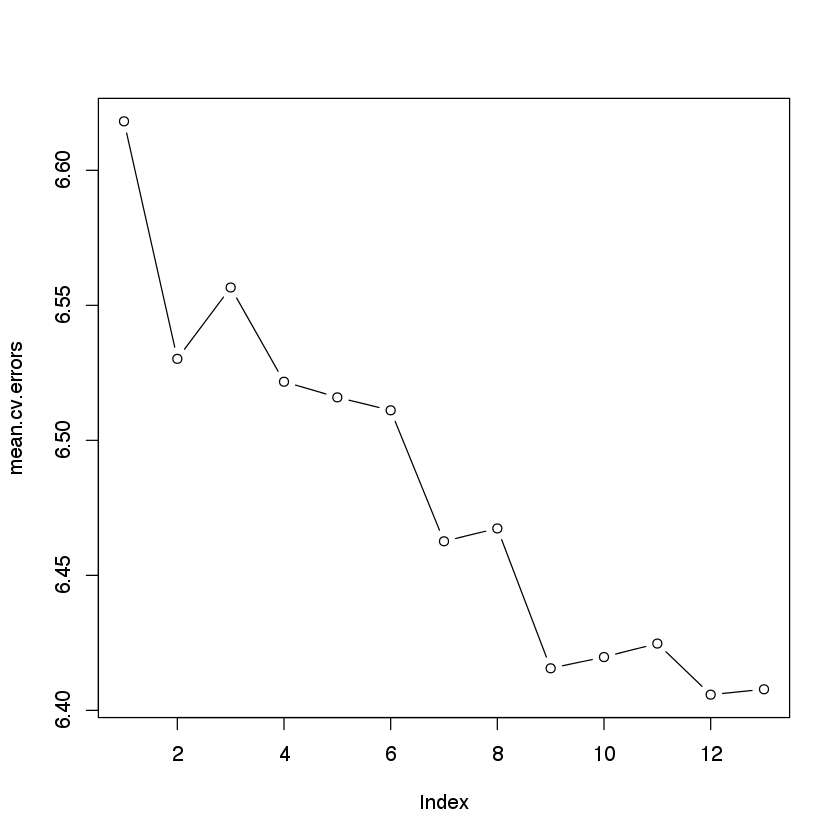

In [58]:
#best subset selection with CV. 模板code
predict.regsubsets=function(object,newdata,id){
    form=as.formula(object$call[[2]])
    mat=model.matrix(form,newdata)
    coefi=coef(object,id=id)
    xvars=names(coefi)
    mat[,xvars]%*%coefi
}
#same here. have to write CV procedures ourself. no prebuid CV in regsubsets
k=10
set.seed(1)
folds=sample(1:k,nrow(Boston),rep=T)
cv.errors=matrix(NA,k,13,dimnames=list(NULL,paste(1:13)))
for(j in 1:k){ #use data not in jth fold
    best.fit=regsubsets(crim~.,data=Boston[folds!=j,],nvmax=13)
    for(i in 1:13){
        pred=predict.regsubsets(best.fit,Boston[folds==j,],id=i)
        cv.errors[j,i]=mean((Boston$crim[folds==j]-pred)^2)
    }
}
mean.cv.errors=sqrt(apply(cv.errors,2,mean))
plot(mean.cv.errors,type="b")
which.min(mean.cv.errors)